###Code and Experiments on Amazon food reviews data for 20000 data using LSTM model

#####Installing correct versions of libraries

In [ ]:
#!pip install q keras==2.2.4
#!pip install q tensorflow==1.15.2
#!pip install q numpy==1.19.5
#!pip install tensorflow-gpu==1.15.2 


In [ ]:
!pip install contractions
# !pip install keras
# !pip install tensorflow

     |████████████████████████████████| 287 kB 9.1 MB/s 
     |████████████████████████████████| 106 kB 48.8 MB/s 


#####Importing all libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile
from pathlib import Path
from io import StringIO
import string  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
import contractions
from nltk.corpus import wordnet
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

2.2.4
1.15.2


Using TensorFlow backend.


In [ ]:
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.layers import LSTM,Input, GRU, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
# from keras import Input

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#####Initializing data size

In [ ]:
data_size=20000

#####Loading dataset

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import collections
from sklearn.model_selection import train_test_split

def load_dataset():
  zf = ZipFile('/content/drive/MyDrive/Amazon_dataset.zip')
  
  df = pd.read_csv(zf.open('Reviews.csv'))

  df.dropna(inplace= True)
  print(df.columns)
  x = df["Text"]
  y = df["Summary"]
  
  # split set
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= .15, random_state= 42, stratify= None )
  x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size= .25, random_state= 42, stratify= None )


  return x_train, x_val, x_test,y_train, y_val,y_test

#####Function to map POS tags 

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts"""
    # tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


#####Function for Preprocessing data

In [ ]:
def preprocessing(data,data_column):
  # train_df = data.drop(['id'], axis=1)
  processed_sent=[]
  for sent in data:
    processed_sent_sub=re.sub("[\(\[].*?[\)\]]", "", sent)
    processed_sent_sub=contractions.fix(processed_sent_sub)
    processed_sent.append(processed_sent_sub)
  WORD = re.compile(r'\w+')
  sentence = []
  for art in processed_sent:
    words = WORD.findall(art)
    # print(words)
    sentence.append(words)
  eng_stopwords = stopwords.words('english')
  punctuation = string.punctuation
  format_sent = []

  for sntc in sentence:
    format_words = []
    for word in sntc:
      if word not in eng_stopwords and word not in punctuation and len(word)>2:
        # word_count +=1
        #word_ = lemmatizer.lemmatize(word.lower())
        format_words.append(word.lower())
    format_words = nltk.pos_tag(format_words)
    doc = [lemmatizer.lemmatize(word[0],get_wordnet_pos(word[1][0].upper())) for word in format_words]
    format_sent.append(" ".join(doc))

  return format_sent

#####Adding start (sos) and end (eos) tokens on summary data

In [ ]:
def add_start_end_token(data):
  data_sos_eos=[]
  for x in data:
    data_sos_eos.append('sos '+x+' eos')

  return data_sos_eos

#####Tokenizing and padding data

In [ ]:
def tokenizer(data):
    tokenizer = Tokenizer(oov_token = "<UNK>")
    #print(tokenizer.num_words)
    tokenizer.fit_on_texts(data)
    
    #print(data[0])
    return tokenizer

def token_fit(data,tokenizer):
    sequences=tokenizer.texts_to_sequences(data)
    word_index=tokenizer.word_index
    print(len(max(sequences,key=len)))
    return sequences,len(max(sequences,key=len)),len(word_index)

def padding(sequences,global_max_len):
    padded = pad_sequences(sequences, padding = "post",maxlen=global_max_len)
    return padded,len(padded[0])

#####Declaring size of hidden and embedding layers

In [ ]:
hidden_dim = 256
embedding_dim = 256

#####Defining the model

In [ ]:
def models(hidden_layer_dimensions, embedding_dimensions, ARTICLE_LEN, ART_VOCAB_SIZE, HIGHLIGHT_LEN, HIGH_VOCAB_SIZE):
  lstm_encoder_ip = Input(shape=(ARTICLE_LEN,))
  encoder_embedding_layer =  Embedding(HIGH_VOCAB_SIZE, embedding_dimensions, trainable=True)
  enc_lstm_1 = LSTM(hidden_layer_dimensions, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
  enc_lstm_2 = LSTM(hidden_layer_dimensions, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
  enc_lstm_3 = LSTM(hidden_layer_dimensions, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0)

  lstm_decoder_ips = Input(shape=(None,))
  decoder_embedding_layer = Embedding(HIGH_VOCAB_SIZE, embedding_dimensions,trainable=True) 
  decoder_lstm = LSTM(hidden_layer_dimensions, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)
  lstm_decoder_dense =  TimeDistributed(Dense(HIGH_VOCAB_SIZE, activation='softmax'))
  
  enc_embedding = encoder_embedding_layer(lstm_encoder_ip)
  encoder_op_1, state_hidden1, state_c1 = enc_lstm_1(enc_embedding)
  encoder_op_2, state_hidden2, state_c2 = enc_lstm_2(encoder_op_1)
  enc_outputs, state_hidden, state_c = enc_lstm_3(encoder_op_2)

  dec_embedding = decoder_embedding_layer(lstm_decoder_ips)
  decoder_outputs, decoder_fwd, decoder_back = decoder_lstm(dec_embedding, initial_state=[state_hidden,state_c])
  
  decoder_outputs = lstm_decoder_dense(decoder_outputs)

  model = Model([lstm_encoder_ip, lstm_decoder_ips], decoder_outputs)
  model.summary()

  #encoder testing
  encoder_testing = Model(inputs=lstm_encoder_ip, outputs =[enc_outputs,state_hidden,state_c])
  encoder_testing.summary()

  #decoder testing
  decoder_state_input = Input(shape=(hidden_layer_dimensions,))
  decoder_hidden_input = Input(shape=(hidden_layer_dimensions,))
  decoder_hidden_state_input = Input(shape=(ARTICLE_LEN,hidden_layer_dimensions))

  dec_embedding2 = decoder_embedding_layer(lstm_decoder_ips)

  
  decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(dec_embedding2, initial_state=[decoder_hidden_input,decoder_state_input])
  print("decoder_outputs_inf",decoder_outputs_inf.shape)
  
  decoder_outputs= lstm_decoder_dense(decoder_outputs_inf)
  
  decoder_testing = Model([lstm_decoder_ips]+[decoder_hidden_state_input,decoder_hidden_input,decoder_state_input], [decoder_outputs]+[state_h_inf,state_c_inf])
  decoder_testing.summary()


  return model,encoder_testing,decoder_testing


#####Loading dataset

In [ ]:
x_train, x_val, x_test,y_train, y_val,y_test=load_dataset()

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


#####Preprocessing train data, test data and validation data

In [ ]:
format_data=preprocessing(x_train[0:data_size],'article')
format_highlight=preprocessing(y_train[0:data_size],'highlights')
format_val_data = preprocessing(x_val[0:data_size],'article')
format_val_highlight = preprocessing(y_val[0:data_size],'highlights')
format_test_data = preprocessing(x_test[0:data_size],'article')
format_test_highlight = preprocessing(y_test[0:data_size],'highlights')

#####Exploring length of text and summary from the data 

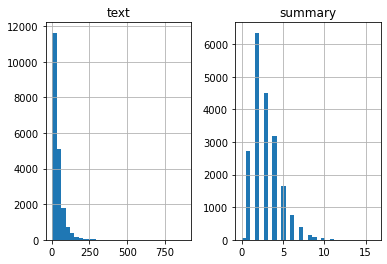

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in format_data:
      text_word_count.append(len(i.split()))

for i in format_highlight:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

#####Removing Outliers from data

In [ ]:
max_text_len=80
max_summary_len=10

In [ ]:
short_text=[]
short_summary=[]
short_val_summary=[]
short_val_text=[]
short_test_summary=[]
short_test_text=[]
for i in range(len(format_data)):
    if(len(format_highlight[i].split())<=max_summary_len and len(format_data[i].split())<=max_text_len):
        short_summary.append(format_highlight[i])
        short_text.append(format_data[i])


for i in range(len(format_val_data)):
    if(len(format_val_highlight[i].split())<=max_summary_len and len(format_val_data[i].split())<=max_text_len):
        short_val_summary.append(format_val_highlight[i])
        short_val_text.append(format_val_data[i])

for i in range(len(format_test_data)):
    if(len(format_test_highlight[i].split())<=max_summary_len and len(format_test_data[i].split())<=max_text_len):
        short_test_summary.append(format_test_highlight[i])
        short_test_text.append(format_test_data[i])

In [ ]:
format_highlight=short_summary
format_data=short_text

format_val_highlight=short_val_summary
format_val_data=short_val_text

format_test_highlight=short_test_summary
format_test_data=short_test_text

#####Tokenizing data 

In [ ]:
#padded_seq,ART_VOCAB_SIZE,ARTICLE_LEN=tokenizer(format_data)
#padded_seq,ART_VOCAB_SIZE,ARTICLE_LEN=tokenizer(format_data)
X_token=tokenizer(format_data)
sos_eos_highlight=add_start_end_token(format_highlight)
Y_token=tokenizer(sos_eos_highlight)

seq,max_len_data,ART_VOCAB_SIZE=token_fit(format_data,X_token)
seq_highlight,max_len_data_highlights,HIGH_VOCAB_SIZE=token_fit(sos_eos_highlight,Y_token)

#padded_val_seq_data, VAL_ART_VOCAB_SIZE, VAL_ART_LEN = tokenizer(format_val_data)
val_seq_data, max_len_val_data, VAL_ART_VOCAB_SIZE= token_fit(format_val_data,X_token)
sos_eos_val_highlight=add_start_end_token(format_val_highlight)
#padded_val_seq_highlight, VAL_HIGH_VOCAB_SIZE, VAL_HIGHLIGHT_LEN = tokenizer(sos_eos_val_highlight)
val_seq_highlight,max_len_val_data_highlights, VAL_HIGH_VOCAB_SIZE= token_fit(sos_eos_val_highlight,Y_token)

#padded_test_seq_data, TEST_ART_VOCAB_SIZE, TEST_ART_LEN = tokenizer(format_test_data)
test_seq_data, max_len_test_data, TEST_ART_VOCAB_SIZE= token_fit(format_test_data,X_token)
sos_eos_test_highlight=add_start_end_token(format_test_highlight)
#padded_test_seq_highlight, TEST_HIGH_VOCAB_SIZE, TEST_HIGHLIGHT_LEN = tokenizer(sos_eos_test_highlight)
test_seq_highlight, max_len_test_data_highlights, TEST_HIGH_VOCAB_SIZE= token_fit(sos_eos_test_highlight,Y_token)

global_max_len_data=max([max_len_data,max_len_val_data,max_len_test_data])
global_max_len_data_highlights=max([max_len_data_highlights,max_len_val_data_highlights,max_len_test_data_highlights])

padded_seq,ARTICLE_LEN=padding(seq,max_text_len)
padded_val_seq_data, VAL_ART_LEN = padding(val_seq_data,max_text_len)
padded_test_seq_data, TEST_ART_LEN = padding(test_seq_data,max_text_len)

padded_seq_highlight,HIGHLIGHT_LEN=padding(seq_highlight,max_summary_len)
padded_val_seq_highlight, VAL_HIGHLIGHT_LEN = padding(val_seq_highlight,max_summary_len)
padded_test_seq_highlight, TEST_HIGHLIGHT_LEN = padding(test_seq_highlight,max_summary_len)

80
12
80
12
80
12


In [ ]:
global_max_highlight_vocab_size = max(HIGH_VOCAB_SIZE,VAL_HIGH_VOCAB_SIZE,TEST_HIGH_VOCAB_SIZE)

global_max_article_vocab_size = max(ART_VOCAB_SIZE,VAL_ART_VOCAB_SIZE,TEST_ART_VOCAB_SIZE)

In [ ]:
K.clear_session()

#####Creating model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
done
done 2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 256)      1406208     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 256), (N 525312      embedding[0][0]                  
_________________________________________________________________________________

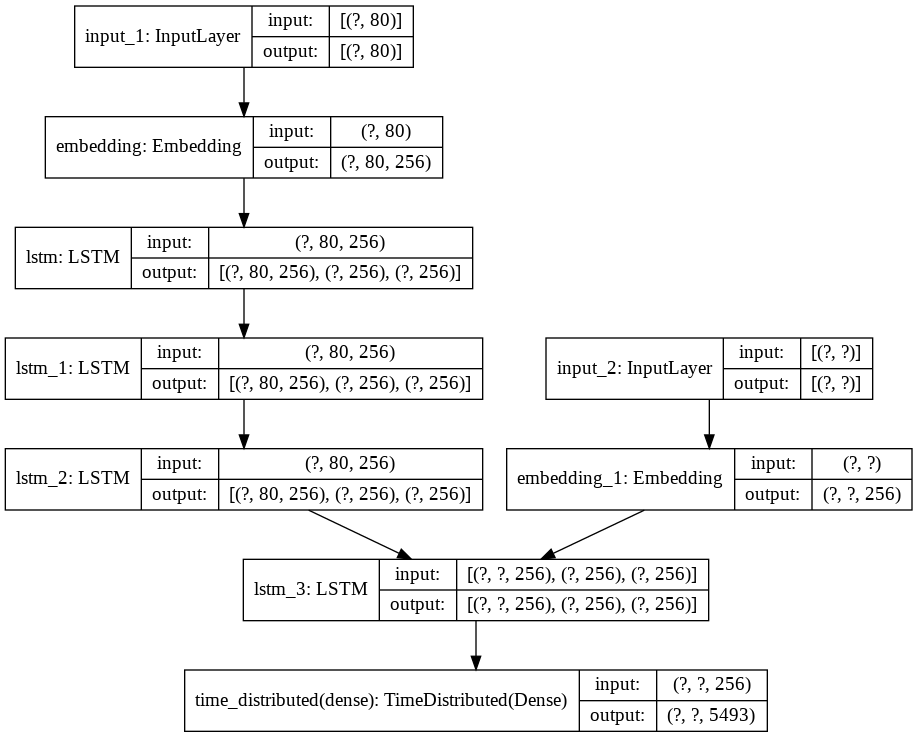

In [ ]:
train_mod,encoder_mod,decode_mod=models(hidden_dim,embedding_dim,max_text_len,global_max_article_vocab_size+1,max_summary_len, global_max_highlight_vocab_size+1)
from tensorflow.keras.utils import plot_model

plot_model(train_mod, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


#####Compiling and Training Model

In [ ]:
from tensorflow.keras import callbacks
class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\n Epoch {} ended".format(epoch))

In [ ]:
train_mod.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = train_mod.fit([padded_seq,padded_seq_highlight[:,:-1]], padded_seq_highlight.reshape(padded_seq_highlight.shape[0],padded_seq_highlight.shape[1], 1)[:,1:] ,epochs=50,callbacks=[CustomCallback()],batch_size= 64, validation_data=([padded_val_seq_data,padded_val_seq_highlight[:,:-1]], padded_val_seq_highlight.reshape(padded_val_seq_highlight.shape[0],padded_val_seq_highlight.shape[1], 1)[:,1:]))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 17986 samples, validate on 17955 samples
Epoch 1/50
17984/17986 [============================>.] - ETA: 0s - loss: 2.4746 - acc: 0.6707
 Epoch 0 ended
17986/17986 [==============================] - 144s 8ms/sample - loss: 2.4747 - acc: 0.6707 - val_loss: 2.3140 - val_acc: 0.6916
Epoch 2/50
17984/17986 [============================>.] - ETA: 0s - loss: 2.2278 - acc: 0.6942
 Epoch 1 ended
17986/17986 [==============================] - 143s 8ms/sample - loss: 2.2278 - acc: 0.6942 - val_loss: 2.2740 - val_acc: 0.6928
Epoch 3/50
17984/17986 [============================>.] - ETA: 0s - loss: 2.1652 - acc: 0.6979
 Epoch 2 ended
17986/17986 [==============================] - 139s 8ms/sample - loss: 2.1652 - acc: 0.6979 - val_loss: 2.2514 - val_acc: 0.6893
Epoch 4/50
17984/17986 [============================>.] - ETA: 0s - loss: 2.1065 - acc: 0.7000
 Epoch 3 ended
17986/17986 [================

#####Plotting training and validation accuracy

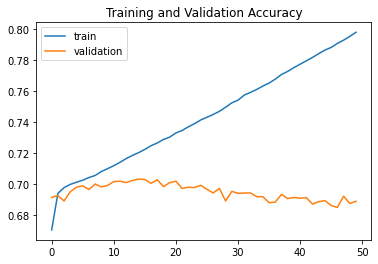

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['acc'], label='train') 
pyplot.plot(history.history['val_acc'], label='validation') 
pyplot.title("Training and Validation Accuracy")
pyplot.legend() 
pyplot.show()

#####Plotting training and validation loss

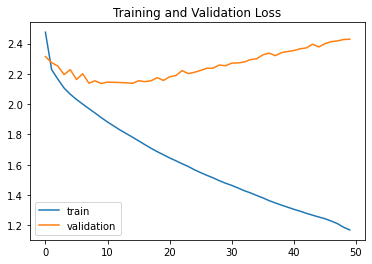

In [ ]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='validation') 
pyplot.title("Training and Validation Loss")
pyplot.legend() 
pyplot.show()


#####Testing Model

In [ ]:
def infer_results(padded_test_seq_data):
  All_sentences = []
  for i in range(len(padded_test_seq_data)):
    inputseq = padded_test_seq_data[i].reshape(1,max_text_len)
    encoder_op,encoder_h,encoder_c=encoder_mod.predict(inputseq)
    infered_op = np.zeros((1,1))

    infered_op[0,0]  = 2
    decoded_sent=[]
    reverse_words=Y_token.index_word
    while True:
      decoder_op,decoder_h,decoder_c=decode_mod.predict([infered_op]+[encoder_op,encoder_h,encoder_c])
      token_index=np.argmax(decoder_op[0,-1,:])
      # print(token_index)
      token=reverse_words[token_index]

      if token!="eos":
        decoded_sent.append(token)

      if token=="eos" or len(decoded_sent)>=global_max_len_data_highlights:
        break

      infered_op[0,0]  = token_index
      encoder_h=decoder_h
      encoder_c=decoder_c

    print("format_test_data[i]:   ",format_test_data[i])
    print("format_test_highlight[i]:   ",format_test_highlight[i])
    sent = " ".join(decoded_sent)
    All_sentences.append(sent)
    print("OUTPUT:   ",sent)
    print("\n")
  return All_sentences

All_sentences = infer_results(padded_test_seq_data)

Streaming output truncated to the last 5000 lines.
format_test_data[i]:    these treat good forgot dog really good nice tall glass cold milk
format_test_highlight[i]:    delicious
OUTPUT:    they love


format_test_data[i]:    these tasty nearly good original wild flavor they also quite stale get
format_test_highlight[i]:    not good wild flavor
OUTPUT:    not expect


format_test_data[i]:    this product invaluable must leave small legged friend home lot day weather bad take highly recommend litter
format_test_highlight[i]:    great work doggie parent
OUTPUT:    what else say product make pick pick


format_test_data[i]:    this chicken noodle soup chicken flavor suppose taste anything like chicken chinese noodle soup chinese asian say right page goodness people want mcdougall chicken noodle soup get instead
format_test_highlight[i]:    chinese noodle soup
OUTPUT:    not quite expect


format_test_data[i]:    very disappointed be expect variety flavor get three flavor bunch leftover h

#####Evaluating Model

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()

In [ ]:
presicion = []
recall = []
f1 = []
print(len(All_sentences))
for (h, r) in zip(All_sentences, format_test_highlight):
    if h != "" and r != "":
      score = rouge.get_scores(h, r)
      print(score)
      s = score[0]['rouge-1']
      presicion.append(s["p"])
      recall.append(s["r"])
      f1.append(s["f"])

print("Precision:",sum(presicion)/len(presicion))
print("Recall:", sum(recall)/len(recall))
print("F1:",sum(f1)/len(f1))

Streaming output truncated to the last 5000 lines.
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
[{'rouge-1': {'r': 0.0, '